## Lectura de ficheros del CR1000 (promedios)

Con este programa leeremos los diferentes ficheros de salida del CR1000 de torre subcanopy (generalmente con nombre CR1000XSeries_flux.dat o similares). Además, se implementará una función para filtrar los nuevos ficheros descargados y añadirlos a fichero excel general donde se almacena la información.

#### Importación de librerias

In [1]:
import sys, os
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import datetime as _datetime
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.dates as mdates

#### Definición de funciones

In [2]:
def read_CR1000_output_file(file_path, feedback = True):
    """
    Esta función leerá el fichero csv (.dat) de salida del CR1000 de torre alta, con el formato 
    interno en el que está escrito el fichero. 
    Funcionará con solo un parámetro de entrada: el nombre del fichero.
    """

    #Leemos el fichero
    data_file = pd.read_csv(file_path, skiprows = [0,2,3], na_values=['NAN'])
    
    #Definimos la cabecera y el índice del dataframe 
    data_file.rename(columns = data_file.iloc[0])
    data_file['TIMESTAMP'] = pd.to_datetime(data_file['TIMESTAMP'], format = "%Y-%m-%d %H:%M:%S")
    data_file = data_file.set_index('TIMESTAMP'); data_file.index.names = ['time']
    
    if feedback: print("The file has been read successfully")
        
    return data_file

def read_CR1000_database_file(file_path, sheets, feedback = True):
    """
    Esta función leerá el fichero excel (.xlxs) donde se almacenan las medidas del CR1000 de torre
    subcanopy con el formato interno de este fichero. 
    Funcionará con solo dos parámetros de entrada: el nombre y la hoja del fichero.
    """
    
    if type(sheets) == str:
        #Leemos el fichero
        data_file = pd.read_excel(file_path, skiprows = [0,2,3], sheet_name = sheets, 
                                  na_values=['NAN', 'INF'])
        #data_file = data_file.drop([0,2,3], axis = 0)
    
        #Definimos la cabecera y el índice del dataframe
        data_file.rename(columns = data_file.iloc[0])
        data_file['TIMESTAMP'] = pd.to_datetime(data_file['TIMESTAMP'], format = "%Y-%m-%d %H:%M:%S")
        data_file = data_file.set_index('TIMESTAMP'); data_file.index.names = ['time']
    
    elif type(sheets) == list:
        data_sheets = []
        for sheet in sheets:
            if feedback: print(f'Reading sheet {sheet}')
            data_sheet = read_CR1000_database_file(file_path, sheet, feedback = False)
            data_sheets.append(data_sheet)
        #Los combinamos
        data_file = pd.concat([data_sheet for data_sheet in data_sheets])
    
        #Puede pasar que combinemos dos ficheros en los que el primero tiene un indice (tiempo) 
        #superior al segundo, por lo que el índice no estaría ordenador. Por ello, hacemos lo 
        #siguiente
        data_file = data_file.sort_index()
    
    if feedback: print("The file has been read successfully")
        
    return data_file

def combine_CR1000_output_files(file_paths, apply_filters = False, output_path = False,
                                feedback = True, debug = False):
    """
    Esta función leerá varios ficheros csv (.dat) de salida del CR1000 de torre subcanopy, con el 
    formato interno en el que están escritos los ficheros. 
    Podrá funcionar con solo un parámetro de entrada: 
     - file_paths, el nombre de los ficheros a leer que vendrán dados en una lista. 
    Tendrá otros parámetros de entrada opcionales:
     - apply_filters: será una variable booleana. El default es False, y no aplicará ningún filtro.
                      En caso de querer aplicar algún filtro, se tendrá que dar una lista de booleanos
                      de la misma longitud que file_paths. Se permite dar apply_filter = True para
                      aplicar los filtros a todos los ficheros.
     - output_path: será la ruta de salida donde se guardará la información. Tendrá que ser un fichero
                    csv, preferiblemente .dat. Cuando output_path = False no se guardarán los datos.
    """
    
    if not feedback:
        _stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    data_files = []; aux = 1
    for file_path in file_paths:
        print(f'*Reading file {aux}')
        data_file = read_CR1000_output_file(file_path, feedback = False)
        data_files.append(data_file); aux += 1
        
    #Filtering (or not)
    if apply_filters == True:
        #Queremos aplicar los filtros a todos los ficheros
        print("All files will be filtered")
        filtered_data_files = []; aux = 1
        for data_file in data_files:
            print(f'*Filtering file {aux}')
            data_file = filter_CR1000_file(data_file, filter_regular_setting = True, 
                                                debug = debug)
            filtered_data_files.append(data_file); aux += 1
        data_files = filtered_data_files
    elif apply_filters == False:
        print("Any file will be filtered")        
    elif type(apply_filters) == list:
        #Aportamos una lista de booleanos, que deberá tener la misma dimension que file_paths
        if len(apply_filters) == len(data_files):
            print("A given set of files will be filtered")
            filtered_data_files = []; aux = 1
            for apply_filter, data_file in zip(apply_filters, data_files):
                if apply_filter:
                    print(f'Filtering file {aux}')
                    data_file = filter_CR1000_file(data_file, filter_regular_setting = True, 
                                                   debug = debug)
                filtered_data_files.append(data_file); aux += 1
            data_files = filtered_data_files
        else:
            print("ERROR. The given set of boolean values missmatched")
    else:
        print("ERROR. Something might have gone wrong")
    
    #Los combinamos
    data = pd.concat([data_file for data_file in data_files])
    
    #Puede pasar que combinemos dos ficheros en los que el primero tiene un indice (tiempo) superior
    #al segundo, por lo que el índice no estaría ordenador. Por ello, hacemos lo siguiente
    data = data.sort_index()
    
    if output_path:
        print("The data has been saved successfully")
        data.to_csv(output_path)
        
    if not feedback: sys.stdout = _stdout
        
    return data
        
def update_CR1000_database_file(excel_data = False, csv_data = False, excel_file = False, 
                                sheets = False, csv_files = False, apply_filters = False, 
                                output_path = False, output_sheet = False,
                                feedback = True, debug = False):
    """
    Esta función actualizará el fichero que hace de base de datos del CR1000 con la información de uno
    o varios ficheros de salida del CR1000. Podrá funcionar por dos vías: que se le den los ficheros 
    ya leidos o que se le de las rutas y hojas de los ficheros que tiene que leer.
    Por ello, se le tendrán que aportar los parámetros excel_data o el par de parámetros (excel_file - 
    sheets), y del mismo modo el parámetro csv_data o el csv_file. 
     - excel_data: variable con los datos de la base de datos previamente leidos y filtrados.
     - csv_data: variable con los datos a actualizar en la base de datos previamente leidos 
                 y filtrados.
     - excel_file: ruta al fichero que hace de base de datos. 
     - sheets: nombre de la hoja (u hojas) a leer del fichero excel_file. Puede ser un str o una list.
     - csv_files: ruta del fichero (o ficheros) a leer con los datos a actualizar en la base de datos. 
                  Puede ser un str o una list.
    Tendrá otros parámetros de entrada opcionales:
     - apply_filters: será una variable booleana. El default es False, y no aplicará ningún filtro.
                      En caso de querer aplicar algún filtro, se tendrá que dar una lista de booleanos
                      de la misma longitud que (excel_paths + csv_file), donde el primer valor de 
                      apply_filers hace referencia al filtrado de excel_file si se utiliza. Se permite 
                      dar apply_filter = True para aplicar los filtros a todos los ficheros.
     - output_path: será la ruta de salida donde se guardará la información. Tendrá que ser un fichero
                    excel, preferiblemente .xlsx. Si output_path = False no se guardarán los datos.
     - output_sheet: será el nombre de la hoja de output_path donde se guardará la infomación.
    """

    if not feedback:
        _stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        
    if apply_filters == True:
        print("All of the files will be filtered")
        apply_csv_filters = True; apply_excel_filters = True
    elif type(apply_filters) == list:
        print("A given set of files will be filtered")
        if excel_file and csv_files: #leeremos los dos tipos de ficheros
            if len(apply_filters) == (len(csv_files) + 1):
                apply_excel_filters = apply_filters[0]
                apply_csv_filters = apply_filters[1:]
            else:
                print("ERROR. The given set of boolean values missmatched")
        elif not excel_file and csv_files: #leemos solamente los ficheros de salida del CR1000
            apply_excel_filters = False
            if len(apply_filters) == len(csv_files):
                apply_csv_filters = apply_filters
            else:
                print("ERROR. The given set of boolean values missmatched")   
        elif excel_file and not csv_files: #leemos solamente el fichero base de datos del CR1000
            apply_csv_filters = False
            if len(apply_filters) == 1:
                apply_excel_filters = apply_filters[0]
            else:
                print("ERROR. The given set of boolean values missmatched")
    else:
        print("Any file will be filtered")
        apply_csv_filters = False; apply_excel_filters = False
        
    if csv_files:
        #Leemos, filtramos y combinamos los fichero
        print("Reading CR1000 output files")
        csv_data = combine_CR1000_output_files(csv_files, apply_filters = apply_csv_filters,
                                               debug = debug)
    if excel_file and sheets:
        #Lectura del fichero
        print("Reading and filtering of CR1000 database file")
        excel_data = read_CR1000_database_file(excel_file, sheets)
        #Filtrado del fichero (se haría igual)
        excel_data = filter_CR1000_file(excel_data, filter_regular_setting = apply_excel_filters, 
                                        debug = debug)  

    #Los combinamos
    data = pd.concat([csv_data, excel_data])
    
    #excel_data tiene su columna de tiempo completa desde el 1 de enero a las 00:00 al 31 de diciembre
    #a las 23:30, mientras que csv_data tiene solamente las horas en las que hay medidas. Por ello, al
    #concatenarlos, hay pares de filas, una vacia (excel) y otra con información (csv), con el misma
    #fecha. Lo que tendremos que hacer es aplicar el filtro al índice
    data = filter_CR1000_file(data, filter_time = True, debug = debug)
    
    #Puede pasar que combinemos dos ficheros en los que el primero tiene un indice (tiempo) superior
    #al segundo, por lo que el índice no estaría ordenador. Al hacer este paso despues del filtrado 
    #del tiempo, conseguimos que en el filtrado se guarden las filas repetidas pero que tienen 
    #información. 
    data = data.sort_index()
    
    if output_path and output_sheet:
        data.to_excel(output_path, sheet_name = output_sheet)
        print("The data has been saved successfully")
        
    print("Update of CR1000 database completed")
    if not feedback: sys.stdout = _stdout
        
    return data

def filter_CR1000_file(data, filter_all = False, filter_regular_setting = False, filter_time = False,
                       filter_record = False, filter_batt = False, 
                       filter_Hs = False, filter_Fc_wpl = False, filter_LE_wpl = False,
                       filter_Hc = False, filter_Fc_irga = False, filter_LE_irga = False,
                       filter_co2_wpl_LE = False, filter_co2_wpl_H = False, filter_h2o_wpl_LE = False,
                       filter_h2o_wpl_H = False, filter_irga_warnings = False, filter_agc = False,
                       filter_u_star = False, filter_Ts = False, filter_stdev_Ts = False, 
                       filter_co2 = False, filter_stdev_co2 = False, filter_h2o = False,
                       filter_stdev_h2o = False, filter_Ux = False, filter_stdev_Ux = False,
                       filter_Uy = False, filter_stdev_Uy = False, filter_Uz = False,
                       filter_stdev_Uz = False,
                       feedback = True, debug = False):
    """
    Se filtrarán prácticamente todos las variables de salida. Se han organizado en diferentes 
    funciones dependiendo del ámbito de cada variable. Así, se filtran:
     - parámetros generales: 'time', 'RECORD' y 'batt_volt_Avg'
     - parámetros del IRGA: 'Hs', 'Fc_wpl', 'LE_wpl', 'Hc', 'Fc_irga', 'LE_irga', 'co2_wpl_LE', 
                            'co2_wpl_H', 'h2o_wpl_LE', 'h2o_wpl_H', 'irga_warnings', 'agc_Avg'
     - parámetros del anemómetro: 'u_star', 'Ts_mean', 'stdev_Ts', 'co2_mean', 'stdev_co2', 'h2o_Avg',
                                  'stdev_h2o', 'Ux_Avg', 'stdev_Ux', 'Uy_Avg', 'stdev_Uy', 'Uz_Avg', 
                                  'stdev_Uz', 'cov_Ts_Ux', 'cov_Ts_Uy', 'cov_Ts_Uz', 'cov_co2_Ux', 
                                  'cov_co2_Uy', 'cov_co2_Uz', 'cov_h2o_Ux', 'cov_h2o_Uy', 
                                  'cov_h2o_Uz', 'cov_Ux_Uy', 'cov_Ux_Uz', 'cov_Uy_Uz'
    Con filter_all pondremos a True todos los parámetros, y con filter_regular_setting ponemos a True
    todos menos filter_record (a False)
    """
    
    if not feedback:
        _stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        
    print("Starting filtering")
    
    if filter_regular_setting: filter_all = True
    if filter_all: #Every filter equals True
        filter_time = True; filter_record = True; filter_batt = True 
        filter_Hs = True; filter_Fc_wpl = True; filter_LE_wpl = True; filter_Hc = True
        filter_Fc_irga = True; filter_LE_irga = True; filter_co2_wpl_LE = True
        filter_co2_wpl_H = True; filter_h2o_wpl_LE = True; filter_h2o_wpl_H = True
        filter_irga_warnings = True; filter_agc = True
        filter_u_star = True; filter_Ts = True; filter_stdev_Ts = True; filter_co2 = True
        filter_stdev_co2 = True; filter_h2o = True; filter_stdev_h2o = True; filter_Ux = True
        filter_stdev_Ux = True; filter_Uy = True; filter_stdev_Uy = True; filter_Uz = True
        filter_stdev_Uz = True
        if filter_regular_setting: filter_record = False
 
    if filter_time or filter_record or filter_batt:
        data = filter_general_parameters(data, filter_time, filter_record, filter_batt, debug)

    if (filter_Hs or filter_Fc_wpl or filter_LE_wpl or filter_Hc or filter_Fc_irga or 
        filter_LE_irga or filter_co2_wpl_LE or filter_co2_wpl_H or filter_h2o_wpl_LE or
        filter_h2o_wpl_H or filter_irga_warnings or filter_agc):
        data = filter_IRGA_parameters(data, filter_Hs, filter_Fc_wpl, filter_LE_wpl, filter_Hc, 
                                      filter_Fc_irga, filter_LE_irga, filter_co2_wpl_LE, 
                                      filter_co2_wpl_H, filter_h2o_wpl_LE, filter_h2o_wpl_H,
                                      filter_irga_warnings, filter_agc, debug)

    if (filter_u_star or filter_Ts or filter_stdev_Ts or filter_co2 or filter_stdev_co2 or
        filter_h2o or filter_stdev_h2o or filter_Ux or filter_stdev_Ux or filter_Uy or
        filter_stdev_Uy or filter_Uz or filter_stdev_Uz):
        data = filter_anemometer_parameters(data, filter_u_star, filter_Ts, filter_stdev_Ts, 
                                            filter_co2, filter_stdev_co2, filter_h2o, 
                                            filter_stdev_h2o, filter_Ux, filter_stdev_Ux,
                                            filter_Uy, filter_stdev_Uy, filter_Uz, filter_stdev_Uz,
                                            debug)
        
    print("Filtering completed")
    if not feedback: sys.stdout = _stdout
    
    return data

def filter_general_parameters(data, filter_time, filter_record, filter_batt, debug):
    """
    Se filtrarán los parámetros 'time', 'RECORD' y 'batt_volt_Avg'. 
     - Para 'time' se mirará que no haya horas repetidas
     - Para 'RECORD' se mirará que no haya valores repetidos 
     - Para 'batt_volt_Avg' se mirará que el valor esté entre 10 V y 14 V
    Si alguno de estas condiciones no se cumplen se borrará el registro completo (la fila)
    """
    
    if filter_time and any(data.index.duplicated()):
        print('Duplicate time found at:')
        print(data[data.index.duplicated()].index)
        print('Proceeding to delete duplicates')
        data = data[~data.index.duplicated(keep='first')]
    
    if filter_record and any(data['RECORD'].duplicated()):
        print('Duplicate record found at:')
        print(data[data['RECORD'].duplicated()].index)
        print('Proceeding to delete duplicates')
        data = data[~data['RECORD'].duplicated(keep='first')]       
            
    if filter_batt and (any(data['batt_volt_Avg'] < 10) or any(data['batt_volt_Avg'] > 14)):
        print('Battery voltage has to be filtered due to the set filtering range')
        idx = np.logical_or(data['batt_volt_Avg'] < 10, data['batt_volt_Avg'] > 14)
        if debug: print(data['batt_volt_Avg'][idx])
        data = data[data['batt_volt_Avg'] > 10]; data = data[data['batt_volt_Avg'] < 14]
    
    return data

def filter_IRGA_parameters(data, filter_Hs, filter_Fc_wpl, filter_LE_wpl, filter_Hc, filter_Fc_irga,
                           filter_LE_irga, filter_co2_wpl_LE, filter_co2_wpl_H, filter_h2o_wpl_LE,
                           filter_h2o_wpl_H, filter_irga_warnings, filter_agc, debug):
    """
    Se filtrarán los parámetros del IRGA. 
    "Hs","Fc_wpl","LE_wpl","Hc"
     - Para 'Hs' se mirará que el valor esté entre ___ W/m2 y ___ W/m2
     - Para 'Fc_wpl' se mirará que el valor esté entre -1 mg/(m2s) y 1 mg/(m2s)
     - Para 'LE_wpl' se mirará que el valor esté entre -50 W/m2 y 250 W/m2
     - Para 'Hc' se mirará que el valor esté entre -70 W/m2 y 400 W/m2
     - Para 'Fc_irga' se mirará que el valor esté entre -1 mg/(m2s) y 1 mg/(m2s)
     - Para 'LE_irga' se mirará que el valor esté entre -50 W/m2 y 250 W/m2
     - Para 'co2_wpl_LE' se mirará que el valor esté entre ___ mg/(m2s) y ___ mg/(m2s)
     - Para 'co2_wpl_H' se mirará que el valor esté entre ___ mg/(m2s) y ___ mg/(m2s)
     - Para 'h2o_wpl_LE' se mirará que el valor esté entre ___ W/m2 y ___ W/m2
     - Para 'h2o_wpl_H' se mirará que el valor esté entre ___ W/m2 y ___ W/m2
     - Para 'irga_warnings' se mirará que el valor sea igual a 0
     - Para 'agc_Avg' se mirará que el valor esté entre 50 y 54
    Si alguna de las condiciones los parámetros de subcolumns no se cumple se pondrá a NAN el valor 
    de todos los parámetros (excepto de 'agc_Avg'). En el caso de 'agc_Avg', si no se cumple su 
    condición se pondrá a NAN su valor y los de los parámetros de subcolumns.
    """
    columns = ['Hs', 'Fc_wpl', 'LE_wpl', 'Hc', 'Fc_irga', 'LE_irga', 'co2_wpl_LE', 'co2_wpl_H',
               'h2o_wpl_LE', 'h2o_wpl_H', 'irga_warnings', 'agc_Avg']
    #subcolumns = ['CO2_dry_Avg', 'H2O_dry_Avg', 'co2_Avg', 'H2O_Avg']
    
    if filter_Fc_wpl and any(np.logical_or(data['Fc_wpl'] < -1, data['Fc_wpl'] > 1)):
        print('Fc_wpl has to be filtered due to the set filtering range')
        idx = np.logical_or(data['Fc_wpl'] < -1, data['Fc_wpl'] > 1)
        if debug: print(data['Fc_wpl'][idx])
        data.at[idx,'Fc_wpl'] = np.nan
        
    if filter_LE_wpl and any(np.logical_or(data['LE_wpl'] < -50, data['Fc_wpl'] > 250)):
        print('LE_wpl has to be filtered due to the set filtering range')
        idx = np.logical_or(data['LE_wpl'] < -50, data['LE_wpl'] > 250)
        if debug: print(data['LE_wpl'][idx])
        data.at[idx,'LE_wpl'] = np.nan

    if filter_Hc and any(np.logical_or(data['Hc'] < -70, data['Hc'] > 400)):
        print('Hc has to be filtered due to the set filtering range')
        idx = np.logical_or(data['Hc'] < -70, data['Hc'] > 400)
        if debug: print(data['Hc'][idx])
        data.at[idx,'Hc'] = np.nan

    if filter_Fc_irga and any(np.logical_or(data['Fc_irga'] < -1, data['Fc_irga'] > 1)):
        print('Fc_irga has to be filtered due to the set filtering range')
        idx = np.logical_or(data['Fc_irga'] < -1, data['Fc_irga'] > 1)
        if debug: print(data['Fc_irga'][idx])
        data.at[idx,'Fc_irga'] = np.nan

    if filter_LE_irga and any(np.logical_or(data['LE_irga'] < -50, data['Fc_irga'] > 250)):
        print('LE_irga has to be filtered due to the set filtering range')
        idx = np.logical_or(data['LE_irga'] < -50, data['LE_irga'] > 250)
        if debug: print(data['LE_irga'][idx])
        data.at[idx,'LE_irga'] = np.nan

    if filter_irga_warnings and any(data['irga_warnings'] != 0):
        print('irga_warnings has to be filtered due to the set filtering range')
        idx = data['irga_warnings'] != 0
        if debug: print(data['irga_warnings'][idx])
        data.at[idx,columns] = np.nan
        
    if filter_agc and any(np.logical_or(data['agc_Avg'] < 50, data['agc_Avg'] > 54)):
        print('AGC has to be filtered due to the set filtering range')
        idx = np.logical_or(data['agc_Avg'] < 50, data['agc_Avg'] > 54)
        if debug: print(data['agc_Avg'][idx])
        data.at[idx,columns] = np.nan
            
    return data

def filter_anemometer_parameters(data, filter_u_star, filter_Ts, filter_stdev_Ts, filter_co2, 
                                 filter_stdev_co2, filter_h2o, filter_stdev_h2o, filter_Ux, 
                                 filter_stdev_Ux, filter_Uy, filter_stdev_Uy, filter_Uz, 
                                 filter_stdev_Uz, debug):
    """
    Se filtrarán los parámetros del anemómetro. 
     - Para 'u_star' se mirará que el valor esté entre 0 m/s y 1 m/s
     - Para 'Ts_mean' se mirará que el valor esté entre -10 °C y 50 °C
     - Para 'stdev_Ts' se mirará que el valor sea menor que 5 °C
     - Para 'co2_mean' se mirará que el valor esté entre 500 mg/m3 y 1000 mg/m3
     - Para 'stdev_co2' se mirará que el valor sea menor que 250 mg/m3
     - Para 'h2o_Avg' se mirará que el valor esté entre 0 g/m3 y 20 g/m3
     - Para 'stdev_h2o' se mirará que el valor sea menor que 4 g/m3
     - Para 'Ux_Avg' se mirará que el valor esté entre -10 m/s y 10 m/s
     - Para 'stdev_Ux' se mirará que el valor sea menor que 3 m/s
     - Para 'Uy_Avg' se mirará que el valor esté entre -10 m/s y 10 m/s
     - Para 'stdev_Uy' se mirará que el valor sea menor que 3 m/s
     - Para 'Uz_Avg' se mirará que el valor esté entre -1 m/s y 1 m/s
     - Para 'stdev_Uz' se mirará que el valor sea menor que 1 m/s
     - Para las covarianzas 'cov_Ts_Ux', 'cov_Ts_Uy', 'cov_Ts_Uz', 'cov_co2_Ux', 'cov_co2_Uy',
       'cov_co2_Uz', 'cov_h2o_Ux', 'cov_h2o_Uy', 'cov_h2o_Uz', 'cov_Ux_Uy', 'cov_Ux_Uz', 'cov_Uy_Uz'
       no se mirará nada
    Si alguna de las condiciones los parámetros de columns no se cumple se pondrá a NAN el valor 
    del parámetro que no cumple su condicion y, si la tuviese, su desviación estandar.
    """
    columns = ['u_star', 'Ts_mean', 'stdev_Ts', 'cov_Ts_Ux', 'cov_Ts_Uy', 'cov_Ts_Uz', 'co2_mean',
               'stdev_co2', 'cov_co2_Ux', 'cov_co2_Uy', 'cov_co2_Uz', 'h2o_Avg', 'stdev_h2o', 
               'cov_h2o_Ux', 'cov_h2o_Uy', 'cov_h2o_Uz', 'Ux_Avg', 'stdev_Ux', 'cov_Ux_Uy', 
               'cov_Ux_Uz', 'Uy_Avg', 'stdev_Uy', 'cov_Uy_Uz', 'Uz_Avg', 'stdev_Uz']
    
    if filter_u_star and any(np.logical_or(data['u_star'] < 0, data['u_star'] > 1)):
        print('u_star has to be filtered due to the set filtering range')
        idx = np.logical_or(data['u_star'] < 0, data['u_star'] > 1)
        if debug: print(data['u_star'][idx])
        data.at[idx,'u_star'] = np.nan

    if filter_Ts and any(np.logical_or(data['Ts_mean'] < -10, data['Ts_mean'] > 50)):
        print('Ts has to be filtered due to the set filtering range')
        idx = np.logical_or(data['Ts_mean'] < -10, data['Ts_mean'] > 50)
        if debug: print(data['Ts_mean'][idx])
        data.at[idx,['Ts_mean','stdev_Ts']] = np.nan
        
    if filter_stdev_Ts and any(data['stdev_Ts'] > 5):
        print('stdev_Ts has to be filtered due to the set filtering range')
        idx = data['stdev_Ts'] > 5
        if debug: print(data['stdev_Ts'][idx])
        data.at[idx,['Ts_mean','stdev_Ts']] = np.nan
        
    if filter_co2 and any(np.logical_or(data['co2_mean'] < 500, data['co2_mean'] > 1000)):
        print('co2 has to be filtered due to the set filtering range')
        idx = np.logical_or(data['co2_mean'] < 500, data['co2_mean'] > 1000)
        if debug: print(data['co2_mean'][idx])
        data.at[idx,['co2_mean','stdev_co2']] = np.nan
        
    if filter_stdev_co2 and any(data['stdev_co2'] > 250):
        print('stdev_co2 has to be filtered due to the set filtering range')
        idx = data['stdev_co2'] > 250
        if debug: print(data['stdev_co2'][idx])
        data.at[idx,['co2_mean','stdev_co2']] = np.nan

    if filter_h2o and any(np.logical_or(data['h2o_Avg'] < 0, data['h2o_Avg'] > 20)):
        print('h2o has to be filtered due to the set filtering range')
        idx = np.logical_or(data['h2o_Avg'] < 0, data['h2o_Avg'] > 20)
        if debug: print(data['h2o_Avg'][idx])
        data.at[idx,['h2o_Avg','stdev_h2o']] = np.nan
        
    if filter_stdev_h2o and any(data['stdev_h2o'] > 4):
        print('stdev_h2o has to be filtered due to the set filtering range')
        idx = data['stdev_h2o'] > 4
        if debug: print(data['stdev_h2o'][idx])
        data.at[idx,['h2o_Avg','stdev_h2o']] = np.nan
        
    if filter_Ux and any(np.logical_or(data['Ux_Avg'] < -10, data['Ux_Avg'] > 10)):
        print('Ux has to be filtered due to the set filtering range')
        idx = np.logical_or(data['Ux_Avg'] < -10, data['Ux_Avg'] > 10)
        if debug: print(data['Ux_Avg'][idx])
        data.at[idx,['Ux_Avg','stdev_Ux']] = np.nan
        
    if filter_stdev_Ux and any(data['stdev_Ux'] > 3):
        print('stdev_Ux has to be filtered due to the set filtering range')
        idx = data['stdev_Ux'] > 3
        if debug: print(data['stdev_Ux'][idx])
        data.at[idx,['Ux_Avg','stdev_Ux']] = np.nan   
        
    if filter_Uy and any(np.logical_or(data['Uy_Avg'] < -10, data['Uy_Avg'] > 10)):
        print('Uy has to be filtered due to the set filtering range')
        idx = np.logical_or(data['Uy_Avg'] < -10, data['Uy_Avg'] > 10)
        if debug: print(data['Uy_Avg'][idx])
        data.at[idx,columns] = np.nan

    if filter_stdev_Uy and any(data['stdev_Uy'] > 3):
        print('stdev_Uy has to be filtered due to the set filtering range')
        idx = data['stdev_Uy'] > 3
        if debug: print(data['stdev_Uy'][idx])
        data.at[idx,['Uy_Avg','stdev_Uy']] = np.nan   
        
    if filter_Uz and any(np.logical_or(data['Uz_Avg'] < -1, data['Uz_Avg'] > 1)):
        print('Uz has to be filtered due to the set filtering range')
        idx = np.logical_or(data['Uz_Avg'] < -1, data['Uz_Avg'] > 1)
        if debug: print(data['Uz_Avg'][idx])
        data.at[idx,columns] = np.nan

    if filter_stdev_Uz and any(data['stdev_Uz'] > 1):
        print('stdev_Uz has to be filtered due to the set filtering range')
        idx = data['stdev_Uz'] > 1
        if debug: print(data['stdev_Uz'][idx])
        data.at[idx,['Uz_Avg','stdev_Uz']] = np.nan  
        
    return data


#Variables que quean por implementar
#Guadiana:
#"tau", "press_mean", "t_hmp_mean", "h2o_hmp_mean", "rho_a_mean", "e_hmp_mean", "rh_hmp_Avg", 
#"wnd_dir_compass", "wnd_dir_csat3", "wnd_spd", "rslt_wnd_spd", "std_wnd_dir", "n_Tot",
#"csat_warnings", "del_T_f_Tot", "sig_lck_f_Tot", "amp_h_f_Tot", "amp_l_f_Tot",
#"chopper_f_Tot", "detector_f_Tot", "pll_f_Tot", "sync_f_Tot", "panel_temp_Avg"

#Conde:



#### Lectura y filtrado del fichero de salida del CR1000

Se podrán hacer ambos procesos juntos o por separado, somo se verá a continuación. En primer lugar veamos cómo se leería y se filtraría por separado UN fichero. Comenzamos leyendo el fichero.

In [11]:
file_path = r"C:\Users\jesus\Desktop\Datos Ecología\CR1000XSeries_flux.dat"
#Lectura del fichero
csv_data = read_CR1000_output_file(file_path, feedback = False)

Una vez leido lo podremos filtrar. Se pueden filtrar todas las variables por separado, aunque se han definido alunas vías más rápidas para no tener que definir una a una las variables. Así, con filter_all = True, nos ahorramos escirbir:

`
filter_time = True, filter_record = True, filter_batt = True, filter_Hs = True, filter_Fc_wpl = True,
filter_LE_wpl = True, filter_Hc = True, filter_Fc_irga = True, filter_LE_irga = True,
filter_co2_wpl_LE = True, filter_co2_wpl_H = True, filter_h2o_wpl_LE = True, filter_h2o_wpl_H = True,
filter_irga_warnings = True, filter_agc = True, filter_u_star = True, filter_Ts = True, filter_stdev_Ts = True, filter_co2 = True, filter_stdev_co2 = True, filter_h2o = True,
filter_stdev_h2o = True, filter_Ux = True, filter_stdev_Ux = True, filter_Uy = True, 
filter_stdev_Uy = True, filter_Uz = True, filter_stdev_Uz = True
`
  
Para mas información sobre cada uno de los parámetros hay que leer la documentación de la función filter_CR1000_file y las consiguientes documentaciones de las funciones a las que llama. Se deja el texto recuadrado por si es algún momento es necesario copiarlo. 

Por otra parte, con filter_regular_setting fijaremos a True todos los parámetros excepto filter_record (fijado a False).

In [12]:
#Filtrado del fichero
csv_data = filter_CR1000_file(csv_data, filter_regular_setting = True, 
                              feedback = False, debug = False)

Por último, podríamos guardar esta información en un fichero similar al leido, pero con las variables filtradas.

In [ ]:
output_file_path = r"C:\Users\jesus\Desktop\Datos Ecología\filtered_prueba.dat"
#Guardamos en un fichero csv
csv_data.to_csv(output_file_path)

Por otra parte, también se puede hacer este proceso de manera directa. Es decir, leer uno o varios ficheros, filtrarlos, combinarlos y finalmente guardar la información en un fichero csv. La dinámica es la misma, pero haremos 

In [ ]:
files = [r"C:\Users\jesus\Desktop\Datos Ecología\CR1000XSeries_flux.dat", 
         r"C:\Users\jesus\Desktop\Datos Ecología\CR1000XSeries_flux_2.dat"]
output_file_path = r"C:\Users\jesus\Desktop\Datos Ecología\filtered_prueba.dat"

#Leemos, filtramos, combinamos y guardamos el fichero
csv_data = combine_CR1000_output_files(files, apply_filters = True, output_path = output_file_path,
                                       feedback = False, debug = False)

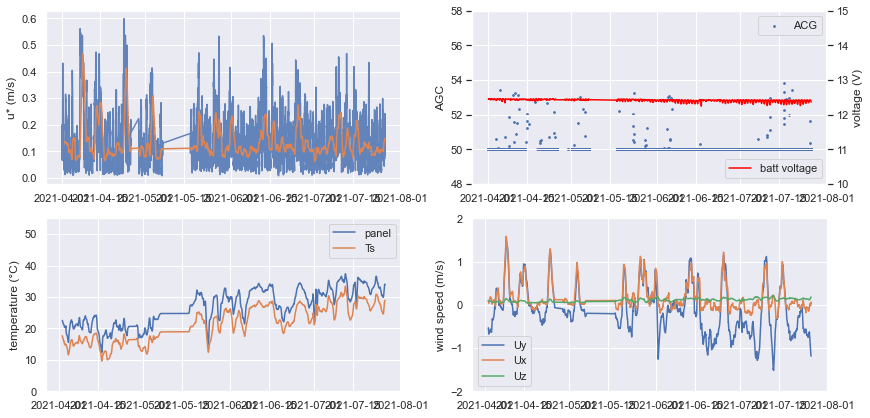

In [15]:
f, axs = plt.subplots(2, 2, figsize = (14,7))
axs[0,0].plot(csv_data['u_star'], alpha = 0.85)
axs[0,0].plot(csv_data['u_star'].rolling(window = 48).mean()); axs[0,0].set_ylabel("u* (m/s)")
axs[0,1].scatter(csv_data.index, csv_data['agc_Avg'], s = 3, label = 'ACG')
axs[0,1].set_ylim(48,58); axs[0,1].set_ylabel("AGC"); axs[0,1].legend()
ax = axs[0,1].twinx(); ax.plot(csv_data['batt_volt_Avg'], color = 'red', label = 'batt voltage')
ax.set_ylim(10,15); ax.set_ylabel("voltage (V)"); ax.legend(loc = 'lower right')
axs[1,0].plot(csv_data['panel_temp_Avg'].rolling(window = 48).mean(), label = 'panel')
axs[1,0].plot(csv_data['Ts_mean'].rolling(window = 48).mean(), label = 'Ts')
axs[1,0].set_ylim(0, 55); axs[1,0].set_ylabel("temperature (°C)"); axs[1,0].legend()
axs[1,1].set_ylim(-2,2); axs[1,1].set_ylabel("wind speed (m/s)")
for u in ['Uy', 'Ux', 'Uz']:
    axs[1,1].plot(csv_data[str(u) + '_Avg'].rolling(window = 48).mean(), label = str(u))
axs[1,1].legend()

#### Lectura y filtrado de la base de datos del CR1000

Se sigue un procedimiento completamente análogo. Por una parte podremos leer y filtrar cada hoja del fichero excel por separado (y guardar).

In [ ]:
file_path = r"C:\Users\jesus\Desktop\Datos Ecología\CR1000_Guadiana_subcanopy_flux.xlsx"
sheets = '2020'
#Lectura del fichero
excel_data_2020 = read_CR1000_database_file(file_path, sheets, feedback = False)

Y una vez leido se podrá filtrar. Notar que para el filtrado se utiliza la misma función que para filtrar los ficheros de salida del CR1000.

In [ ]:
#Filtrado del fichero
excel_data_2020 = filter_CR1000_file(excel_data_2020, filter_regular_setting = True, 
                                     feedback = False, debug = False)

Por último podemos guardar esta información filtrada en una hoja de un fichero excel.

In [ ]:
output_file_path = r"C:\Users\jesus\Desktop\Datos Ecología\CR1000_Guadiana_prueba_filtered.xlsx"
sheet = '2020'
#Guardamos en una hoja de un fichero excel
excel_data_2020.to_excel(output_file_path, sheet_name = sheet)

Por otra parte, también se pueden leer varias hojas del mismo fichero.

In [ ]:
file_path = r"C:\Users\jesus\Desktop\Datos Ecología\CR1000_Guadiana_subcanopy_flux.xlsx"
sheets = ['2021', '2020']
#Lectura del fichero
excel_data = read_CR1000_database_file(file_path, sheets, feedback = False)

#Filtrado del fichero (se haría igual)
excel_data = filter_CR1000_file(excel_data, filter_regular_setting = True, 
                                feedback = False, debug = False)

In [ ]:
f, axs = plt.subplots(2, 2, figsize = (14,7))
axs[0,0].plot(excel_data['u_star'], alpha = 0.85)
axs[0,0].plot(excel_data['u_star'].rolling(window = 48).mean()); axs[0,0].set_ylabel("u* (m/s)")
axs[0,1].scatter(excel_data.index, excel_data['agc_Avg'], s = 3, label = 'ACG')
axs[0,1].set_ylim(48,58); axs[0,1].set_ylabel("AGC"); axs[0,1].legend()
ax = axs[0,1].twinx(); ax.plot(excel_data['batt_volt_Avg'], color = 'red',label = 'batt voltage')
ax.set_ylim(10,15); ax.set_ylabel("voltage (V)"); ax.legend(loc = 'lower right')
axs[1,0].plot(excel_data['panel_temp_Avg'].rolling(window = 48).mean(), label = 'panel')
axs[1,0].plot(excel_data['Ts_mean'].rolling(window = 48).mean(), label = 'Ts')
axs[1,0].set_ylim(0, 55); axs[1,0].set_ylabel("temperature (°C)"); axs[1,0].legend()
axs[1,1].set_ylim(-2,2); axs[1,1].set_ylabel("wind speed (m/s)")
for u in ['Uy', 'Ux', 'Uz']:
    axs[1,1].plot(excel_data[str(u) + '_Avg'].rolling(window = 48).mean(), label = str(u))
axs[1,1].legend()

#### Actualización de la base de datos del CR1000

Finalmente, lo que queda por ver es la actualización de la base de datos del CR1000. Es decir, la lectura y filtrado de un fichero csv de salida del CR1000; la lectura y posible filtrado de la hoja del fichero excel que hace de base de datos; la concatenación de los datos; y finalmente el guardado de estos datos en una hoja del fichero excel que hace de base de datos. 

Por ello, en primer lugar leemos y filtramos los dos tipos de ficheros en cuestion.

In [3]:
#Ficheros de salida del CR1000
files = [r"C:\Users\jesus\Desktop\Datos Ecología\CR1000XSeries_flux.dat", 
         r"C:\Users\jesus\Desktop\Datos Ecología\CR1000XSeries_flux_2.dat",
         r"C:\Users\jesus\Desktop\Datos Ecología\CR1000XsubcanopyGua_flux_1.dat",
         r"C:\Users\jesus\Desktop\Datos Ecología\CR1000XsubcanopyGua_flux_2.dat"]


#Leemos, filtramos, combinamos y guardamos el fichero
csv_data = combine_CR1000_output_files(files, apply_filters = True, feedback = False, debug = False)

#---------------------------------------------------------------------------------------------------
#Fichero de la base de datos del CR1000
file_path = r"C:\Users\jesus\Desktop\Datos Ecología\CR1000_Guadiana_subcanopy_flux.xlsx"
sheets = ['2021']

#Lectura del fichero
excel_data = read_CR1000_database_file(file_path, sheets, feedback = False)
#Filtrado del fichero (se haría igual)
excel_data = filter_CR1000_file(excel_data, filter_regular_setting = True, 
                                feedback = False, debug = False)

Una vez están filtrados podemos llamar a la función que actualiza la base de datos con los ficheros de entrada.

In [5]:
#Fichero de salida
output_file_path = r"C:\Users\jesus\Desktop\Datos Ecología\CR1000_Guadiana_prueba_filtered.xlsx"
output_sheet = '2021'

_excel_data = update_CR1000_database_file(excel_data = excel_data, csv_data = csv_data, 
                                          output_path = output_file_path, output_sheet = output_sheet,
                                          feedback = False, debug = False)

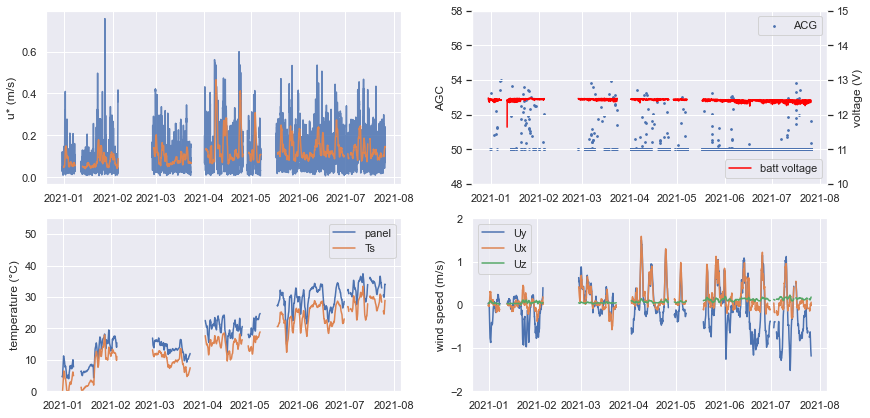

In [17]:
f, axs = plt.subplots(2, 2, figsize = (14,7))
axs[0,0].plot(_excel_data['u_star'], alpha = 0.85)
axs[0,0].plot(_excel_data['u_star'].rolling(window = 48).mean()); axs[0,0].set_ylabel("u* (m/s)")
axs[0,1].scatter(_excel_data.index, _excel_data['agc_Avg'], s = 3, label = 'ACG')
axs[0,1].set_ylim(48,58); axs[0,1].set_ylabel("AGC"); axs[0,1].legend()
ax = axs[0,1].twinx(); ax.plot(_excel_data['batt_volt_Avg'], color = 'red',label = 'batt voltage')
ax.set_ylim(10,15); ax.set_ylabel("voltage (V)"); ax.legend(loc = 'lower right')
axs[1,0].plot(_excel_data['panel_temp_Avg'].rolling(window = 48).mean(), label = 'panel')
axs[1,0].plot(_excel_data['Ts_mean'].rolling(window = 48).mean(), label = 'Ts')
axs[1,0].set_ylim(0, 55); axs[1,0].set_ylabel("temperature (°C)"); axs[1,0].legend()
axs[1,1].set_ylim(-2,2); axs[1,1].set_ylabel("wind speed (m/s)")
for u in ['Uy', 'Ux', 'Uz']:
    axs[1,1].plot(_excel_data[str(u) + '_Avg'].rolling(window = 48).mean(), label = str(u))
axs[1,1].legend()

También se podrá hacer todo el proceso en una sola llamada a la función update_CR1000_database_file(). Esta útlima posibilidad es por tanto la forma más directa de hacer el proceso.

In [9]:
#Ficheros de salida del CR1000
csv_files = [r"C:\Users\jesus\Desktop\Datos Ecología\CR1000XSeries_flux.dat", 
             r"C:\Users\jesus\Desktop\Datos Ecología\CR1000XSeries_flux_2.dat",
             r"C:\Users\jesus\Desktop\Datos Ecología\CR1000XsubcanopyGua_flux_1.dat",
             r"C:\Users\jesus\Desktop\Datos Ecología\CR1000XsubcanopyGua_flux_2.dat"]

#Fichero de la base de datos del CR1000
excel_file = r"C:\Users\jesus\Desktop\Datos Ecología\CR1000_Guadiana_subcanopy_flux.xlsx"
sheets = ['2021']

#Fichero de salida
output_file_path = r"C:\Users\jesus\Desktop\Datos Ecología\CR1000_Guadiana_prueba_filtered.xlsx"
output_sheet = '2021'

_excel_data = update_CR1000_database_file(excel_file = excel_file, sheets = sheets,
                                          csv_files = csv_files, apply_filters = True,
                                          output_path =output_file_path,  output_sheet = output_sheet,
                                          feedback = False, debug = False)

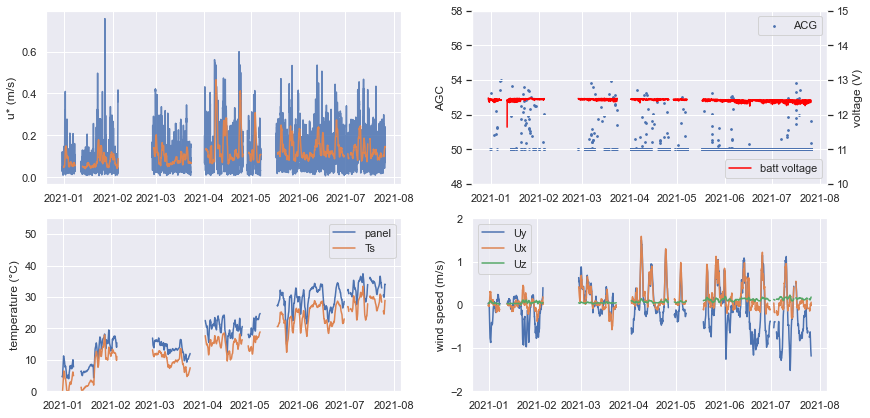

In [16]:
f, axs = plt.subplots(2, 2, figsize = (14,7))
axs[0,0].plot(_excel_data['u_star'], alpha = 0.85)
axs[0,0].plot(_excel_data['u_star'].rolling(window = 48).mean()); axs[0,0].set_ylabel("u* (m/s)")
axs[0,1].scatter(_excel_data.index, _excel_data['agc_Avg'], s = 3, label = 'ACG')
axs[0,1].set_ylim(48,58); axs[0,1].set_ylabel("AGC"); axs[0,1].legend()
ax = axs[0,1].twinx(); ax.plot(_excel_data['batt_volt_Avg'], color = 'red',label = 'batt voltage')
ax.set_ylim(10,15); ax.set_ylabel("voltage (V)"); ax.legend(loc = 'lower right')
axs[1,0].plot(_excel_data['panel_temp_Avg'].rolling(window = 48).mean(), label = 'panel')
axs[1,0].plot(_excel_data['Ts_mean'].rolling(window = 48).mean(), label = 'Ts')
axs[1,0].set_ylim(0, 55); axs[1,0].set_ylabel("temperature (°C)"); axs[1,0].legend()
axs[1,1].set_ylim(-2,2); axs[1,1].set_ylabel("wind speed (m/s)")
for u in ['Uy', 'Ux', 'Uz']:
    axs[1,1].plot(_excel_data[str(u) + '_Avg'].rolling(window = 48).mean(), label = str(u))
axs[1,1].legend()

#### Particularidades de la estación de Conde

Inicialmente el código fue pensado para el CR3000 de la estación de Guadiana, ya que se utilizó de referencia. El CR3000 de la estación de Guadiana produce unos archivos de salida muy similares, por los que con un par de cambios (que el usuario no tiene por qué notar) se pude implementar su uso con este código. Solamente se encuentran incompatibilidades en las variables que aparecen a la salida del CR3000 de Conde: `'rain_Tot', 'SKY_679_up_Avg', 'SKY_798_up_Avg', 'SKY_679_down_Avg', 'SKY_798_down_Avg', 'NDVI_Avg'`; y otros que no aparecen: `'VWC_1_Avg', 'EC_1_Avg', 'Temp_1_Avg', 'VWC_2_Avg', 'EC_2_Avg', 'Temp_2_Avg', 'VWC_3_Avg', 'EC_3_Avg', 'Temp_3_Avg', 'VWC_4_Avg', 'EC_4_Avg', 'Temp_4_Avg', 'VWC_5_Avg', 'EC_5_Avg', 'Temp_5_Avg', 'VWC_6_Avg', 'EC_6_Avg', 'Temp_6_Avg'`.

In [ ]:
files = [r"C:\Users\jesus\Desktop\Datos Ecología\CR3000_Conde.dat"]

#Leemos, filtramos, combinamos y guardamos el fichero
csv_data = combine_CR3000_output_files(files, apply_filters = True, feedback = False, debug = False)

In [ ]:
f, ax1 = plt.subplots(1, 1, figsize = (6,4))
ax1.plot(csv_data['NDVI_Avg'][np.logical_and(csv_data['NDVI_Avg'] > -0.7,
                                             csv_data['NDVI_Avg'] < 1)].rolling(window = 40).mean(),
            label = 'NDVI'); ax1.set_ylim(-0.2, 1); ax1.set_ylabel("NDVI"); ax1.legend()
ax2 = ax1.twinx(); ax2.plot(csv_data['rain_Tot'].rolling(window = 2).mean(), 
                            color = 'red', label = 'total rain', alpha = 0.5)
ax2.set_ylim(0,3); ax2.set_ylabel("rain (mm)"); ax2.legend(loc = 'lower right')


Del mismo, modo podemos leer los ficheros que sirven de base de datos para la estación de Conde.

In [ ]:
file_path = r"C:\Users\jesus\Desktop\Datos Ecología\CR3000_Conde.xlsx"
sheets = ['CON_2021', 'CON_2020']
#Lectura del fichero
excel_data = read_CR1000_database_file(file_path, sheets, feedback = False)

#Filtrado del fichero (se haría igual)
excel_data = filter_CR1000_file(excel_data, filter_regular_setting = True, 
                                       feedback = False, debug = False)

In [ ]:
f, axs = plt.subplots(2, 2, figsize = (14,7))
axs[0,0].plot(excel_data['albedo_Avg'], alpha = 0.85)
axs[0,0].plot(excel_data['albedo_Avg'].rolling(window=10).mean()); axs[0,0].set_ylabel("albedo")
axs[0,1].scatter(excel_data.index, excel_data['AGC_Avg'], s = 3, label = 'ACG')
axs[0,1].set_ylim(0,100); axs[0,1].set_ylabel("AGC"); axs[0,1].legend()
ax = axs[0,1].twinx(); ax.plot(excel_data['batt_volt_Avg'], color = 'red', label = 'batt voltage')
ax.set_ylim(10,15); ax.set_ylabel("voltage (V)"); ax.legend(loc = 'lower right')
axs[1,0].plot(excel_data['AirTC_Avg'].rolling(window = 5).mean(), label = 'Air')
axs[1,0].plot(excel_data['Tsoil_media'].rolling(window = 15).mean(), label = 'Soil')
axs[1,0].set_ylim(-10, 45); axs[1,0].set_ylabel("temperature (°C)"); axs[1,0].legend()
axs[1,1].plot(excel_data['NDVI_Avg'][np.logical_and(excel_data['NDVI_Avg'] > -0.7,
              excel_data['NDVI_Avg'] < 1)].rolling(window = 40).mean(), label = 'NDVI')
axs[1,1].set_ylim(-0.2, 1); axs[1,1].set_ylabel("NDVI"); axs[1,1].legend()
ax2 = axs[1,1].twinx(); ax2.plot(excel_data['rain_Tot'].rolling(window = 2).mean(), 
                                 color = 'red', label = 'total rain', alpha = 0.5)
ax2.set_ylim(0,3); ax2.set_ylabel("rain (mm)"); ax2.legend(loc = 'lower right')

Estos ficheros también se pueden actualizar con los ficheros de salida del CR3000

In [ ]:
#Ficheros de salida del CR3000
csv_files = [r"C:\Users\jesus\Desktop\Datos Ecología\CR3000_Conde.dat"]

#Fichero de la base de datos del CR3000
excel_file = r"C:\Users\jesus\Desktop\Datos Ecología\CR3000_Conde.xlsx"
sheets = ['CON_2021']

#Fichero de salida
output_file_path = r"C:\Users\jesus\Desktop\Datos Ecología\CR3000_Conde_prueba_filtered.xlsx"
output_sheet = "CON_2021"

excel_data = update_CR3000_database_file(excel_file = excel_file, sheets = sheets,
                                         csv_files = csv_files, apply_filters = True,
                                         output_path =output_file_path,  output_sheet = output_sheet,
                                         feedback = False, debug = False)

In [ ]:
f, axs = plt.subplots(2, 2, figsize = (14,7))
axs[0,0].plot(excel_data['albedo_Avg'], alpha = 0.85)
axs[0,0].plot(excel_data['albedo_Avg'].rolling(window=10).mean()); axs[0,0].set_ylabel("albedo")
axs[0,1].scatter(excel_data.index, excel_data['AGC_Avg'], s = 3, label = 'ACG')
axs[0,1].set_ylim(0,100); axs[0,1].set_ylabel("AGC"); axs[0,1].legend()
ax = axs[0,1].twinx(); ax.plot(excel_data['batt_volt_Avg'], color = 'red', label = 'batt voltage')
ax.set_ylim(10,15); ax.set_ylabel("voltage (V)"); ax.legend(loc = 'lower right')
axs[1,0].plot(excel_data['AirTC_Avg'].rolling(window = 5).mean(), label = 'Air')
axs[1,0].plot(excel_data['Tsoil_media'].rolling(window = 15).mean(), label = 'Soil')
axs[1,0].set_ylim(-10, 45); axs[1,0].set_ylabel("temperature (°C)"); axs[1,0].legend()
axs[1,1].plot(excel_data['NDVI_Avg'][np.logical_and(excel_data['NDVI_Avg'] > -0.7,
              excel_data['NDVI_Avg'] < 1)].rolling(window = 40).mean(), label = 'NDVI')
axs[1,1].set_ylim(-0.2, 1); axs[1,1].set_ylabel("NDVI"); axs[1,1].legend()
ax2 = axs[1,1].twinx(); ax2.plot(excel_data['rain_Tot'].rolling(window = 2).mean(), 
                                 color = 'red', label = 'total rain', alpha = 0.5)
ax2.set_ylim(0,3); ax2.set_ylabel("rain (mm)"); ax2.legend(loc = 'lower right')